In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import gt_parser
import os
from tqdm import tqdm

In [6]:
root = "/home/ysheng/Dataset/soft_shadow/train/"
sub_folder = "notsimulated_combine_male_short_outfits_genesis8_armani_casualoutfit03_Base_Pose_Standing_A"
out_folder = "/home/ysheng/Dataset/soft_shadow/single_human/"
test_path = os.path.join(root, os.path.join(sub_folder, "ground_truth.txt"))

test_path = "/home/ysheng/Dataset/soft_shadow/train/notsimulated_combine_male_short_outfits_genesis8_armani_casualoutfit03_Base_Pose_Standing_A/ground_truth.txt"
gt_dict = gt_parser.parse(test_path)
print(len(gt_dict))

5720


In [11]:
dataset_folder = '/home/ysheng/DS/new_dataset'
folders = [os.path.join(dataset_folder, f) for f in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, f))]

output_file = os.path.join(dataset_folder, 'metadata.csv')

def get_files(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    
with open(output_file, 'w') as f:
    for folder in tqdm(folders):
        # files = get_files(os.path.join(folder, 'base'))
        files = get_files(folder)
        
        prefix_set = set()
        for file in files:
            dir_name, basename = os.path.dirname(file),os.path.basename(file)
            if basename.find('shadow') != -1:
                print(basename)
                prefix = basename[:basename.find('_')]
                prefix_set.add(os.path.join(dir_name, prefix))
        prefix_set = list(prefix_set)
        prefix_set.sort()
        for p in prefix_set:
            f.write('{}_mask.npy,{}_shadow.npy\n'.format(p,p))

100%|██████████| 67/67 [00:00<00:00, 7107.73it/s]

000_shadow.npy
000_shadow.npy
000_shadow.npy


In [11]:
dataset_folder = '/home/ysheng/Dataset/soft_shadow/train'

out_file = os.path.join(dataset_folder, "metadata.csv")

gt_parser.parse_folder(dataset_folder, out_file)

0it [00:00, ?it/s]

[ 0.32863899  0.87604355 -0.35290807]
-0.8209919324829877 1.0675955846737388
j: 42, i: 189


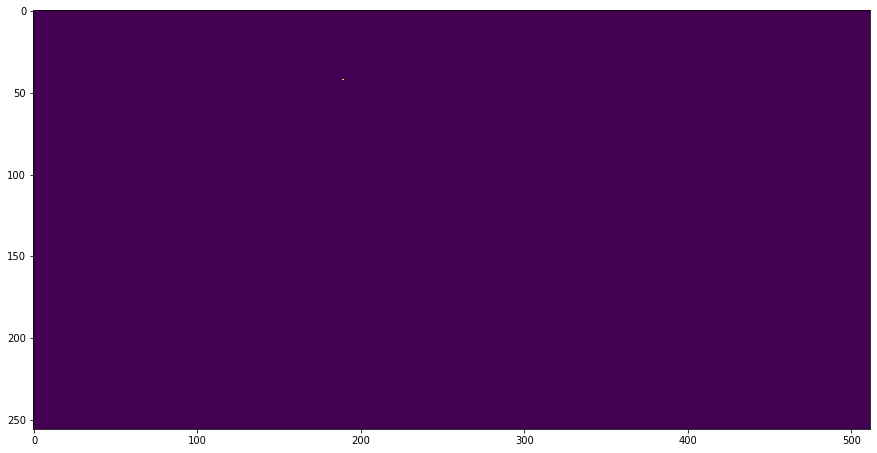

85.33333333333334


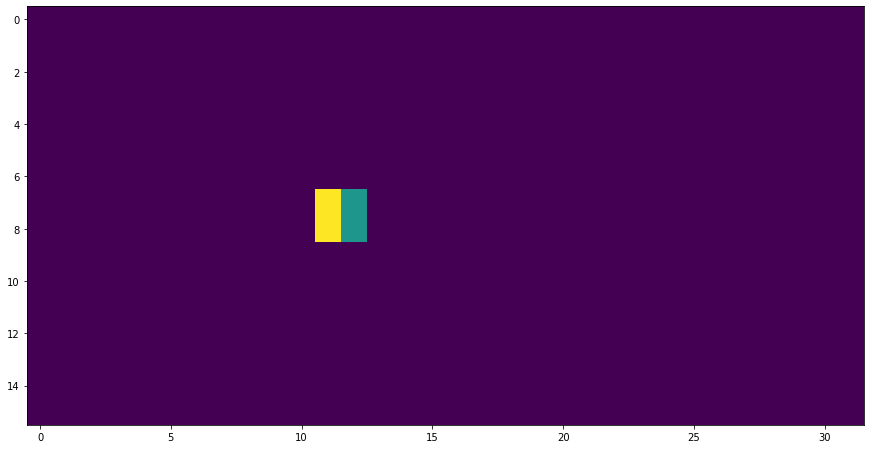

85.33333333333334


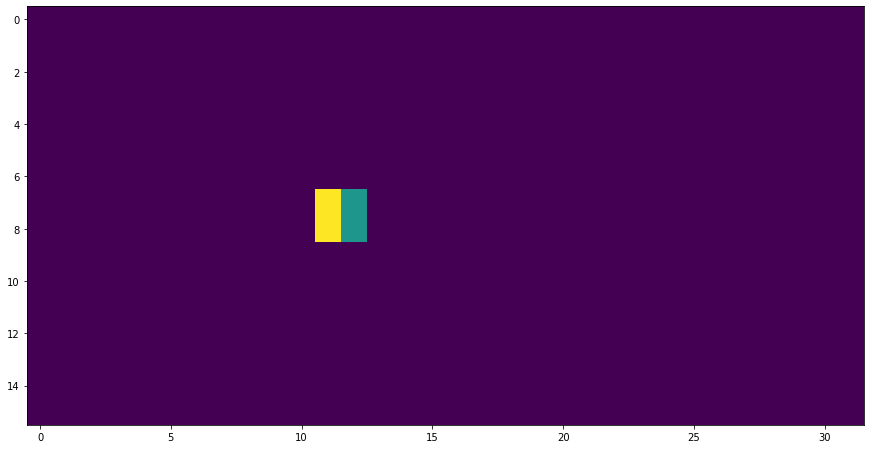

0it [00:00, ?it/s]


In [43]:
import csv
from tqdm import tqdm
from parallel_render_light import get_vector
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def show_np(img):
    plt.figure(figsize=(15,10))
    plt.imshow(img)
    plt.show()

def crop_ibl(ibl_np):
    """input  256x512 ibl
       output 16x32 cropp
    """
    cropped_row = 256 - (30/90 + 1.0) * 0.5 * 256
    print(cropped_row)
    cropped = ibl_np[:int(cropped_row),:]
    return np.array(Image.fromarray(cropped).resize((32,16), Image.BILINEAR))

def render_ibl(alpha, beta):
    ori_ibl_h,ori_ibl_w = 256, 512
    i,j = 0.5 * (alpha + np.pi)/np.pi ,(beta + 0.5*np.pi)/np.pi 
    i,j = int(i * ori_ibl_w), ori_ibl_h-int(j * ori_ibl_h)
    print('j: {}, i: {}'.format(j, i))
    ibl_img = np.zeros((ori_ibl_h, ori_ibl_w))
    ibl_img[j, i] = 1.0
    show_np(ibl_img)
    return crop_ibl(ibl_img)
    
with open(out_file) as f:
    rows = csv.reader(f,delimiter=',')
    for r in tqdm(rows):
        relative_vector = get_vector(r[6])
        relative_vector = relative_vector/np.linalg.norm(relative_vector,2)        
        print(relative_vector)
        
        beta = np.arcsin(relative_vector[1])
        alpha = np.arctan2(relative_vector[2], relative_vector[0])
        print(alpha, beta)
        
        ibl_img = render_ibl(alpha, beta)
        show_np(ibl_img)
        
        # resize_ibl = Image.fromarray(ibl_img)
        # resize_ibl = np.array(resize_ibl.resize((32,16), Image.BILINEAR))
        resize_ibl = crop_ibl(ibl_img)
        show_np(resize_ibl)
        
        break

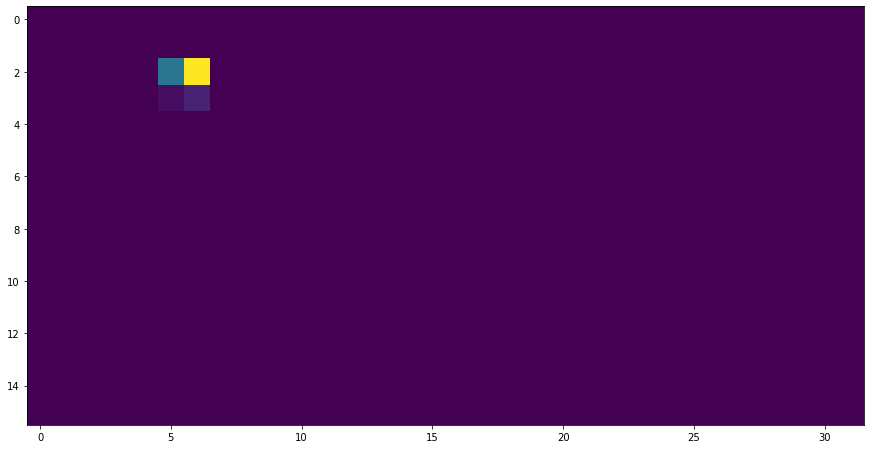

(256, 256, 4)


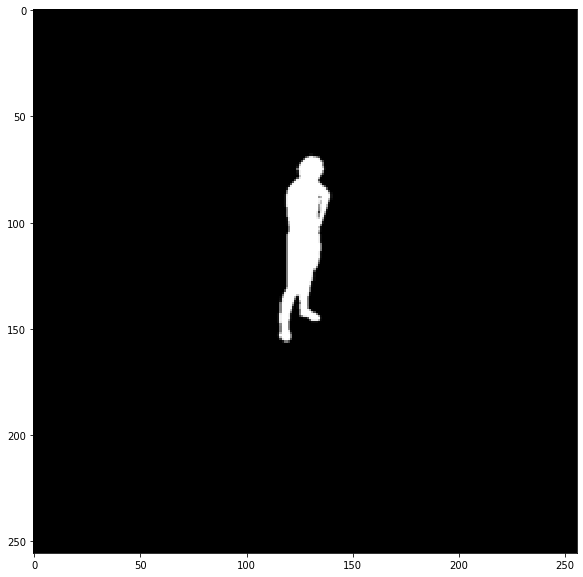

In [41]:
file_path = '/home/ysheng/Dataset/soft_shadow/train/notsimulated_combine_male_short_outfits_genesis8_armani_casualoutfit03_Base_Pose_Standing_A/imgs/0000294_light.npy'
img_np = np.load(file_path)
show_np(img_np)

file_path = '/home/ysheng/Dataset/soft_shadow/train/notsimulated_combine_male_short_outfits_genesis8_armani_casualoutfit03_Base_Pose_Standing_A/imgs/0000294_mask.png'
mask_img = plt.imread(file_path)
print(mask_img.shape)
show_np(mask_img)

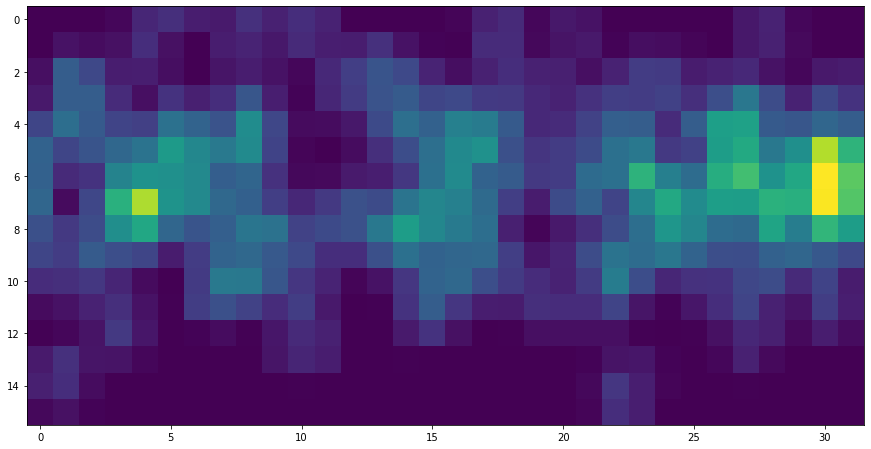

In [47]:
import os
path = '/home/ysheng/Dataset/soft_shadow/train/notsimulated_combine_male_short_outfits_genesis8_armani_casualoutfit03_Base_Pose_Standing_A/imgs/'
files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and f.find('npy') !=-1]

sum_ibl = np.zeros((16,32))
for f in files:
    ibl_f = os.path.join(path, f)
    ibl = np.load(ibl_f)
    sum_ibl += ibl
    
sum_ibl = sum_ibl/len(files)
plt.figure(figsize=(15,10))
plt.imshow(sum_ibl)
plt.savefig('test.png')

In [4]:
import csv
import numpy as np
import os
from shadow_render import render_shadow
import matplotlib.pyplot as plt
from tqdm import tqdm

"""input: x_y_z
   output: np array
"""
def get_vector(vec_str):
    x_ind = vec_str.find('_')
    x = float(vec_str[:x_ind])
    y_ind = vec_str[x_ind + 1:].find('_')
    
    x = float(vec_str[:x_ind])
    y = float(vec_str[x_ind + 1:x_ind + 1 + y_ind])
    z = float(vec_str[x_ind + 1 + y_ind + 1:])
    return np.array([x,y,z])

with open(out_file) as f:
    csv_read = csv.reader(f, delimiter=',')
    mask_path_list, rel_vec_list = [],[]
    for r in csv_read:
        mask_path_list.append(r[1])
        rel_vec_list.append(r[-1])
    